In [1]:
from adodbapi.ado_consts import directions
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import multiprocessing
import sys
import cartopy.feature as cfeature
import cmaps
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tq
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
from cartopy.util import add_cyclic_point
from matplotlib import gridspec
from matplotlib import ticker
from matplotlib.pyplot import quiverkey
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import filters

from toolbar.significance_test import corr_test
from toolbar.TN_WaveActivityFlux import TN_WAF_3D, TN_WAF
from toolbar.curved_quivers.modplot import *
from toolbar.data_read import *

def corr(time_series, data):
    # 计算相关系数
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以标准化
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（标准差乘积）
    denominator = np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2))

    # 相关系数
    correlation = numerator / denominator

    # 重塑为 (lat, lon)
    correlation_map = correlation.reshape(data.shape[1:])
    return correlation_map

def regress(time_series, data):
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以中心化（标准化自变量和因变量）
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差的分子）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（自变量的平方和）
    denominator = np.sum(time_series_mean ** 2)

    # 计算回归系数
    regression_coef = numerator / denominator
    correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
    # 重塑为 (lat, lon)
    regression_map = regression_coef.reshape(data.shape[1:])
    correlation_map = correlation.reshape(data.shape[1:])
    return regression_map, correlation_map

K_type = xr.open_dataset(r"D:/PyFile/p2/data/Time_type_AverFiltAll0.9%_0.3%_3.nc")

In [ ]:
# z
z_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'z')
z_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'z')
z = xr.concat([z_high, z_low], dim='level')
# u
u_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'u')
u_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'u')
u = xr.concat([u_high, u_low], dim='level')
# v
v_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'v')
v_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'v')
v = xr.concat([v_high, v_low], dim='level')
# t
t_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 't')
t_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 't')
t = xr.concat([t_high, t_low], dim='level')
# pre
pre = prec("E:/data/NOAA/PREC/precip.mon.anom.nc", 1961, 2022)
# sst
sst = ersst("E:/data/NOAA/ERSSTv5/sst.mnmean.nc", 1961, 2022)
Z = z.sel(time=slice('1961-01-01', '2022-12-31'))
Z = Z.sel(time=Z['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
U = u.sel(time=slice('1961-01-01', '2022-12-31'))
U = U.sel(time=U['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
V = v.sel(time=slice('1961-01-01', '2022-12-31'))
V = V.sel(time=V['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
T = t.sel(time=slice('1961-01-01', '2022-12-31'))
T = T.sel(time=T['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
Pre = pre.sel(time=slice('1961-01-01', '2022-12-31')).sel(time=pre['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'lat', 'lon')
Sst = sst.sel(time=slice('1961-01-01', '2022-12-31')).sel(time=sst['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'lat', 'lon')

In [2]:
Z = xr.open_dataset(r"D:/PyFile/p2/data/Z.nc").sel(level=[100, 150, 200, 500, 850])
U = xr.open_dataset(r"D:/PyFile/p2/data/U.nc").sel(level=[100, 150, 200, 500, 850])
V = xr.open_dataset(r"D:/PyFile/p2/data/V.nc").sel(level=[100, 150, 200, 500, 850])
T = xr.open_dataset(r"D:/PyFile/p2/data/T.nc").sel(level=[100, 150, 200, 500, 850])
Pre = xr.open_dataset(r"D:/PyFile/p2/data/pre.nc")
Sst = xr.open_dataset(r"D:/PyFile/p2/data/sst.nc")

In [3]:
# 计算相关系数
corr_z = np.zeros((2, len(K_type['type']), len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z = np.zeros((len(K_type['type']), len(Z['level']), len(Z['lat']), len(Z['lon'])))
corr_u = np.zeros((2, len(K_type['type']), len(U['level']), len(U['lat']), len(U['lon'])))
corr_v = np.zeros((2, len(K_type['type']), len(V['level']), len(V['lat']), len(V['lon'])))
corr_t = np.zeros((2, len(K_type['type']), len(T['level']), len(T['lat']), len(T['lon'])))
corr_pre = np.zeros((2, len(K_type['type']), len(Pre['lat']), len(Pre['lon'])))
corr_sst = np.zeros((2, len(K_type['type']), len(Sst['lat']), len(Sst['lon'])))

for i in tq.trange(len(K_type['type'])):
    time_series = K_type.sel(type=i+1)['K'].data
    if i != 1:
        time_series = (time_series - np.mean(time_series))/np.std(time_series)
        for j in tq.trange(len(Z['level'])):
            lev = Z['level'][j].data
            corr_z[0, i, j], corr_z[1, i, j] = regress(time_series, Z['z'].sel(level=lev).data)
            corr_u[0, i, j], corr_u[1, i, j] = regress(time_series, U['u'].sel(level=lev).data)
            corr_v[0, i, j], corr_v[1, i, j] = regress(time_series, V['v'].sel(level=lev).data)
            corr_t[0, i, j], corr_t[1, i, j] = regress(time_series, T['t'].sel(level=lev).data)
            reg_z[i, j] = np.array([np.polyfit(time_series, f, 1)[0] for f in Z['z'].sel(level=lev).transpose('lat', 'lon', 'year').data.reshape(-1,len(time_series))]).reshape(Z['z'].sel(level=lev).data.shape[1], Z['z'].sel(level=lev).data.shape[2])
        corr_pre[0, i], corr_pre[1, i] = regress(time_series, Pre['pre'].data)
        corr_sst[0, i], corr_sst[1, i] = regress(time_series, Sst['sst'].data)
    else:
        time_series = time_series[:-1]
        time_series = (time_series - np.mean(time_series))/np.std(time_series)
        for j in tq.trange(len(Z['level'])):
            lev = Z['level'][j].data
            corr_z[0, i, j], corr_z[1, i, j] = regress(time_series, Z['z'].sel(level=lev, year=slice(1961, 2021)).data)
            corr_u[0, i, j], corr_u[1, i, j] = regress(time_series, U['u'].sel(level=lev, year=slice(1961, 2021)).data)
            corr_v[0, i, j], corr_v[1, i, j] = regress(time_series, V['v'].sel(level=lev, year=slice(1961, 2021)).data)
            corr_t[0, i, j], corr_t[1, i, j] = regress(time_series, T['t'].sel(level=lev, year=slice(1961, 2021)).data)
            reg_z[i, j] = np.array([np.polyfit(time_series, f, 1)[0] for f in Z['z'].sel(level=lev, year=slice(1961, 2021)).transpose('lat', 'lon', 'year').data.reshape(-1,len(time_series))]).reshape(Z['z'].sel(level=lev, year=slice(1961, 2021)).data.shape[1], Z['z'].sel(level=lev, year=slice(1961, 2021)).data.shape[2])
        corr_pre[0, i], corr_pre[1, i] = regress(time_series, Pre['pre'].sel(year=slice(1961, 2021)).data)
        corr_sst[0, i], corr_sst[1, i] = regress(time_series, Sst['sst'].sel(year=slice(1961, 2021)).data)

corr_z = xr.Dataset({'corr': (['type', 'level', 'lat', 'lon'], corr_z[1]),
                     'reg': (['type', 'level', 'lat', 'lon'], corr_z[0])},
                    coords={'type': K_type['type'].data,
                            'level': Z['level'].data,
                            'lat': Z['lat'].data,
                            'lon': Z['lon'].data}).interp(lon=np.arange(0, 360, 0.5), lat=np.arange(-90, 90.1, 0.5))
corr_u = xr.Dataset({'corr': (['type', 'level',  'lat', 'lon'], corr_u[1]),
                    'reg': (['type', 'level', 'lat', 'lon'], corr_u[0])},
                    coords={'type': K_type['type'].data,
                            'level': U['level'].data,
                            'lat': U['lat'].data,
                            'lon': U['lon'].data}).interp(lon=np.arange(0, 360, 0.5), lat=np.arange(-90, 90.1, 0.5))
corr_v = xr.Dataset({'corr': (['type', 'level', 'lat', 'lon'], corr_v[1]),
                   'reg': (['type', 'level', 'lat', 'lon'], corr_v[0])},
                    coords={'type': K_type['type'].data,
                            'level': V['level'].data,
                            'lat': V['lat'].data,
                            'lon': V['lon'].data}).interp(lon=np.arange(0, 360, 0.5), lat=np.arange(-90, 90.1, 0.5))
corr_t = xr.Dataset({'corr': (['type', 'level', 'lat', 'lon'], corr_t[1]),
                   'reg': (['type', 'level', 'lat', 'lon'], corr_t[0])},
                    coords={'type': K_type['type'].data,
                            'level': T['level'].data,
                            'lat': T['lat'].data,
                            'lon': T['lon'].data}).interp(lon=np.arange(0, 360, 0.5), lat=np.arange(-90, 90.1, 0.5))
corr_pre = xr.Dataset({'corr': (['type', 'lat', 'lon'], corr_pre[1]),
                      'reg': (['type', 'lat', 'lon'], corr_pre[0])},
                      coords={'type': K_type['type'].data,
                              'lat': Pre['lat'].data,
                              'lon': Pre['lon'].data}).interp(lon=np.arange(0, 360, 0.5), lat=np.arange(-90, 90.1, 0.5), kwargs={"fill_value": "extrapolate"})
corr_sst = xr.Dataset({'corr': (['type', 'lat', 'lon'], corr_sst[1]),
                     'reg': (['type', 'lat', 'lon'], corr_sst[0])},
                      coords={'type': K_type['type'].data,
                              'lat': Sst['lat'].data,
                              'lon': Sst['lon'].data})

100%|██████████| 5/5 [01:11<00:00, 14.36s/it]
C:\Users\86136\AppData\Local\Temp\ipykernel_4760\3344043125.py:65: RuntimeWarning: invalid value encountered in divide
  correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
100%|██████████| 3/3 [03:34<00:00, 71.36s/it]


In [4]:
def latlon_fmt(ax, xticks1, yticks1, xmajorLocator, xminorLocator, ymajorLocator, yminorLocator):
    ax.set_yticks(yticks1, crs=ccrs.PlateCarree())
    ax.set_xticks(xticks1, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(which='major', length=4, width=.5, color='black')
    ax.tick_params(which='minor', length=2, width=.2, color='black')
    ax.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
    plt.rcParams['ytick.direction'] = 'out'
    ax.tick_params(axis='both', labelsize=6, colors='black')

In [ ]:
U['u'].sel(level=[150, 200, 500]).mean('year').data

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'edgecolor'
  result = super().contourf(*args, **kwargs)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:547: RuntimeWarning: divide by zero encountered in divide
  draw_probability = thinning_min_wind / wind_0

路径积分: 100%|██████████| 1128/1128 [00:14<00:00, 76.97points/s]
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the

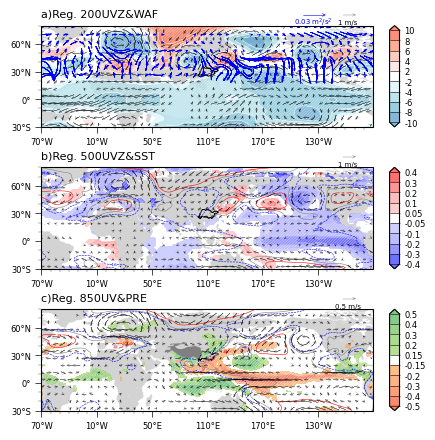

 33%|███▎      | 1/3 [01:24<02:49, 84.91s/it]C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'edgecolor'
  result = super().contourf(*args, **kwargs)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:547: RuntimeWarning: divide by zero encountered in divide
  draw_probability = thinning_min_wind / wind_0

路径积分: 100%|██████████| 1128/1128 [00:12<00:00, 91.33points/s]
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ig

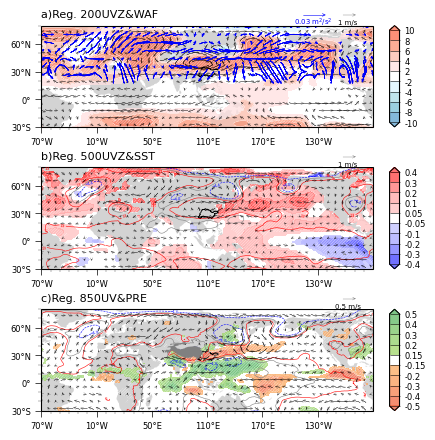

 67%|██████▋   | 2/3 [02:42<01:20, 80.71s/it]C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'edgecolor'
  result = super().contourf(*args, **kwargs)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:547: RuntimeWarning: divide by zero encountered in divide
  draw_probability = thinning_min_wind / wind_0

路径积分: 100%|██████████| 1128/1128 [00:13<00:00, 80.76points/s]
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ig

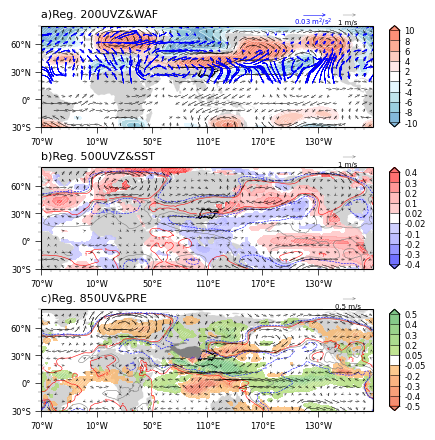

100%|██████████| 3/3 [04:06<00:00, 82.15s/it]


In [8]:
from matplotlib.colors import BoundaryNorm
from matplotlib import colors
from toolbar.significance_test import r_test


# 绘图
for ipic in tq.trange(len(K_type['type'])):
    p_th = r_test(62, 0.1) if ipic!=1 else r_test(61, 0.1)# 62为样本量，0.1为显著性水平
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots
    gs = gridspec.GridSpec(3, 1)
    xticks1 = np.arange(-180, 180, 10)
    yticks1 = np.arange(-30, 81, 30)
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180-70))
    ax1.set_title(f"a)Reg. 200UVZ&WAF", fontsize=8, loc='left')
    # ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.25)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.set_extent([-180, 180, -30, 80], crs=ccrs.PlateCarree(central_longitude=0))
    latlon_fmt(ax1, xticks1, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(corr_z['reg'].sel(type=ipic+1, level=[150, 200, 500]),
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z= TN_WAF_3D(Uc, Vc, GEOa, Tc)
    reg_z_, lon = add_cyclic_point(corr_z['reg'].sel(type=ipic+1, level=200), coord=corr_z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z['corr'].sel(type=ipic+1, level=200), coord=corr_z['lon'])
    lev_z = np.array([-10, -8, -6, -4, -2, 2, 4, 6, 8, 10])
    reg_z_ = np.where((np.abs(reg_z_) < 30), np.nan, reg_z_)
    waf_contf = ax1.contourf(lon, corr_z['lat'], reg_z_/9.8,
                                           levels=lev_z,
                                           cmap=cmaps.temp_diff_18lev[5:-5],
                                           extend='both', alpha=.75,
                                           transform=ccrs.PlateCarree(central_longitude=0))
    waf_cont = ax1.contour(lon, corr_z['lat'], reg_z_/9.8, colors='white', levels=lev_z, linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    #ax1.quiver(lon, corr_z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax1.contourf(lon, corr_z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none', linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'

    wind = Curlyquiver(ax1, corr_u['lon'], corr_u['lat'], corr_u['reg'].sel(type=ipic+1, level=200), corr_v['reg'].sel(type=ipic+1, level=200),
                                  center_lon=110, arrowsize=.5, scale=5, linewidth=0.15, regrid=15,
                                   color='k', thinning=['50%', 'min'], nanmax=20/3)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k')
    WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x.sel(lat=np.arange(0, 90))['lat'],
                                  waf_x.sel(lat=np.arange(0, 90), level=200), waf_y.sel(lat=np.arange(0, 90), level=200),
                                  regrid=10, center_lon=110, arrowsize=.5, scale=5, linewidth=0.4,
                                  color='blue', thinning=['45%', 'min'], nanmax=0.1)
    WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.7, ud=7.7, edgecolor='none', arrowsize=.5)
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
    # 色标
    ax1_colorbar = inset_axes(ax1, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    cb1 = plt.colorbar(waf_contf, cax=ax1_colorbar, orientation='vertical', drawedges=True)
    cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb1.locator = ticker.FixedLocator(lev_z)
    cb1.set_ticklabels([str(lev) for lev in lev_z])
    cb1.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度

    ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180-70))
    ax2.set_title(f"b)Reg. 500UVZ&SST", fontsize=8, loc='left')
    # ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.25)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.set_extent([-180, 180, -30, 80], crs=ccrs.PlateCarree(central_longitude=0))
    latlon_fmt(ax2, xticks1, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # z
    positive_values = corr_z['reg'].sel(type=ipic+1, level=500).data[corr_z['reg'].sel(type=ipic+1, level=500).data > 0]
    q_positive = np.round(np.percentile(positive_values, 33.3)) if positive_values.size > 0 else 0
    positive_values = corr_z['reg'].sel(type=ipic+1, level=500).data[corr_z['reg'].sel(type=ipic+1, level=500).data < 0]
    q_positive_ = np.round(np.percentile(positive_values, 66.6)) if positive_values.size > 0 else 0
    z_high = ax2.contour(corr_z['lon'], corr_z['lat'], corr_z['reg'].sel(type=ipic+1, level=500), colors='red', levels=[q_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_O = ax2.contour(corr_z['lon'], corr_z['lat'], corr_z['reg'].sel(type=ipic+1, level=500), colors='gray', levels=[0], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(corr_z['lon'], corr_z['lat'], corr_z['reg'].sel(type=ipic+1, level=500), colors='blue', levels=[q_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=3)
    z_low.clabel(inline=1, fontsize=3)
    reg_sst_, lon = add_cyclic_point(corr_sst['reg'].sel(type=ipic+1), coord=corr_sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst['corr'].sel(type=ipic+1), coord=corr_sst['lon'])
    # sst
    lev_sst = np.array([-.4, -.3, -.2, -.1, -.05, .05, .1, .2, .3, .4]) if ipic != 2 else np.array([-.4, -.3, -.2, -.1, -.02,.02,.1,.2,.3,.4])
    reg_sst_ = np.where((np.abs(reg_sst_) < 0.05), np.nan, reg_sst_) if ipic!= 2 else np.where((np.abs(reg_sst_) < 0.02), np.nan, reg_sst_)
    sst = ax2.contourf(lon, corr_sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10-2] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10+2:-2], levels=lev_sst, extend='both', transform=ccrs.PlateCarree(central_longitude=0), alpha=0.75)
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    #ax2.quiver(lon, corr_sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)

    # 显著性
    p_hatches = ax2.contourf(lon, corr_sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none', linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'

    # wind
    wind = Curlyquiver(ax2, corr_u['lon'], corr_u['lat'], corr_u['reg'].sel(type=ipic+1, level=500), corr_v['reg'].sel(type=ipic+1, level=500),
                                  center_lon=110, arrowsize=.5, scale=5, linewidth=0.15, regrid=15,
                                  color='k', nanmax=wind.nanmax, thinning=['50%', 'min'])
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k')
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb2 = plt.colorbar(sst, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb2.locator = ticker.FixedLocator(lev_sst)
    cb2.set_ticklabels([str(lev) for lev in lev_sst])
    cb2.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度

    ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree(central_longitude=110))
    ax3.set_title(f"c)Reg. 850UV&PRE", fontsize=8, loc='left')
    # ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.25)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=10)
    ax3.set_extent([-180, 180, -30, 80], crs=ccrs.PlateCarree(central_longitude=0))
    ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    reg_pre_, lon = add_cyclic_point(corr_pre['reg'].sel(type=ipic+1), coord=corr_pre['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre['corr'].sel(type=ipic+1), coord=corr_pre['lon'])
    lev_pre = np.array([-.5, -.4, -.3, -.2, -.15, .15, .2, .3, .4, .5]) if ipic != 2 else np.array([-.5, -.4, -.3, -.2, -.05, .05, .2, .3, .4, .5])
    reg_pre_ = np.where((np.abs(reg_pre_) <= 0.15), np.nan, reg_pre_) if ipic!= 2 else np.where((np.abs(reg_pre_) <= 0.05), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(lon, corr_pre['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56-10] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72+10:106-0], levels=lev_pre, extend='both', transform=ccrs.PlateCarree(central_longitude=0), alpha=0.75)
    pre_edge = ax3.contour(lon, corr_pre['lat'], reg_pre_, colors='white', levels=lev_pre, linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, corr_pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # z
    positive_values = corr_z['reg'].sel(type=ipic+1, level=850).data[corr_z['reg'].sel(type=ipic+1, level=500).data > 0]
    q_positive = np.round(np.percentile(positive_values, 33.3)) if positive_values.size > 0 else 0
    positive_values = corr_z['reg'].sel(type=ipic+1, level=850).data[corr_z['reg'].sel(type=ipic+1, level=500).data < 0]
    q_positive_ = np.round(np.percentile(positive_values, 66.6)) if positive_values.size > 0 else 0
    z_high = ax3.contour(corr_z['lon'], corr_z['lat'], corr_z['reg'].sel(type=ipic+1, level=850), colors='red', levels=[q_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_O = ax3.contour(corr_z['lon'], corr_z['lat'], corr_z['reg'].sel(type=ipic+1, level=850), colors='gray', levels=[0], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(corr_z['lon'], corr_z['lat'], corr_z['reg'].sel(type=ipic+1, level=850), colors='blue', levels=[q_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=3)
    z_low.clabel(inline=1, fontsize=3)

    # 显著性
    p_hatches = ax3.contourf(lon, corr_pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'

    # wind
    wind = Curlyquiver(ax3, corr_u['lon'], corr_u['lat'], corr_u['reg'].sel(type=ipic+1, level=850), corr_v['reg'].sel(type=ipic+1, level=850), center_lon=110, arrowsize=.5, scale=2.5, linewidth=0.15, regrid=15,
                                color='k', nanmax=wind.nanmax, thinning=['50%', 'min'])
    wind.key(fig, U=.5, label='0.5 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k')
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax3_colorbar = inset_axes(ax3, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax3.transAxes, borderpad=0)
    cb3 = plt.colorbar(pre, cax=ax3_colorbar, orientation='vertical', drawedges=True)
    cb3.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb3.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb3.locator = ticker.FixedLocator(lev_pre)
    cb3.set_ticklabels([str(lev) for lev in lev_pre])
    cb3.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度
    plt.savefig(f'D:/PyFile/p2/pic/各空间型异常环流场{ipic}.png', dpi=600, bbox_inches='tight')
    plt.show()


In [ ]:
if 1:
    #100hPa 西部型相关
    ipic = 2
    fig = plt.figure(figsize=(10, 5))
    ax2 = fig.add_subplot(311, projection=ccrs.PlateCarree(central_longitude=180-70))
    ax2.set_title(f"d)Corr. 100ZUV", fontsize=8, loc='left')
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.25)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    ax2.set_extent([-180, 180, -30, 80], crs=ccrs.PlateCarree(central_longitude=0))
    latlon_fmt(ax2, xticks1, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # z
    z = ax2.contour(Z['lon'], Z['lat'], corr_z[ipic, 0, :, :], colors='w',
                    levels=[-.25, -.2, -.15, -.1, -.05, .05,.1, .15, .2, .25], linewidths=0.4,
                    transform=ccrs.PlateCarree(central_longitude=0), linestyles='solid')
    corr_sst_, lon = add_cyclic_point(corr_z[ipic, 0, :, :], coord=Z['lon'])
    sst = ax2.contourf(lon, Z['lat'], corr_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.25, -.2, -.15, -.1, -.05, .05,.1, .15, .2, .25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    ax2.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], corr_u[ipic, 3, :, :], corr_v[ipic, 3, :, :],
                                  center_lon=110, arrowsize=.5, scale=30, linewidth=0.2, regrid=20,
                                  color='k')
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k')
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb2 = plt.colorbar(sst, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb2.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度
    plt.savefig(f'D:/PyFile/p2/pic/各空间型异常环流场100hPa.pdf', dpi=600, bbox_inches='tight')

In [ ]:
if 1:
    from matplotlib.path import Path
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import matplotlib.path as mpath
    # ice 西部型相关
    ice = xr.open_dataset(r"E:\data\NOAA\HadISST\HadISST_ice.nc")
    ice = ice.sel(time=slice('1961-01-01', '2022-12-31'))['sic']
    ice = ice.sel(time=ice['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'latitude', 'longitude')
    time_series = K_type.sel(type=2)['K'].data
    time_series = time_series - np.polyval(np.polyfit(range(len(time_series)), time_series, 1), range(len(time_series)))
    time_series = (time_series - np.mean(time_series))/np.std(time_series)
    corr_ = corr(time_series, ice.data)
    # 创建北极极射投影，中央经线设为110E
    proj = ccrs.NorthPolarStereo(central_longitude=110)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_title("Corr. SIC")

    # 设置地图范围为北纬50度以上
    ax.set_extent([-180, 360, 50, 90], ccrs.PlateCarree())

    # 添加地理特征
    ax.add_feature(cfeature.COASTLINE.with_scale('110m'))
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # 绘制相关填色图（假设corr的经纬度为1D）
    lons, lats = np.meshgrid(ice.longitude, ice.latitude)
    pcm = ax.pcolormesh(lons, lats, corr_,
                        transform=ccrs.PlateCarree(),
                        cmap=cmaps.BlueDarkRed18_r,
                        vmin=-.35, vmax=.35,
                        shading='auto')  # 自动处理网格

    # 添加颜色条
    cbar = plt.colorbar(pcm, ax=ax, shrink=0.6, drawedges=True)
    cbar.label_style = {'size': 14}
        # 创建圆形路径用于设置图像边界
    theta = np.linspace(0, 2 * np.pi, 120)
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    center, radius = [0.5, 0.5], 0.5
    circle = mpath.Path(verts * radius + center)

    # 设置图形边界为圆形
    ax.set_boundary(circle, transform=ax.transAxes)

    # 设置网格线
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.ylocator = mticker.FixedLocator([50, 60, 70, 80, 90])
    gl.xlocator = mticker.FixedLocator(np.arange(0, 360, 30))  # 经度从0到360
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    plt.savefig(f'D:/PyFile/p2/pic/SIC_type3.png', dpi=600, bbox_inches='tight')
    plt.show()